# Classification - Titanic

Simone Richetti, mat.129180, attività 5.

### Traccia
Scaricare e studiare i dati sui passeggeri del Titanic disponibili su https://www.kaggle.com/c/titanic (scheda
“Data”). Quindi, risolvere il problema di “prevedere” la sopravvivenza o meno di ciascuno dei passeggeri in
base alle loro caratteristiche, usando un classificatore Naïve Bayes. In particolare, studiare quali feature usare
e come modellarle, scrivere il codice Python/NLTK e valutare l’accuratezza dei risultati ottenuti
(eventualmente, è possibile anche fare confronti di efficacia tra più “configurazioni”, es. diversi set di feature,
ecc.)

### Dipendenze

In [1]:
import pandas as pd
import os
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

---

## Exploratory Data Analysis
La competizione Kaggle indicata fornisce un training set su cui trainare e validare il nostro modello e un test set senza *groundtruth* su cui fare predizioni e da sottomettere per ottenere un rank nella competizione. 

Poichè questo ultimo aspetto non è di nostro interesse, importiamo solo il training set e ne studiamo la struttura:

In [2]:
titanic_df = pd.read_csv(os.path.join('titanic-data', 'train.csv'))

print(titanic_df.shape)
print(titanic_df.columns)
titanic_df.head()

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Riportiamo alcune informazioni sul dataset:
* *Survived*: è la feature che vogliamo predire, 1=sopravvissuto, 0=morto;
* *PClass*: classe del biglietto, prima, seconda o terza;
* *SibSp*: numero di fratelli/sorelle/coniugi a bordo;
* *Parch*: numero di genitori/figli a bordo;
* *Fare*: prezzo del biglietto;
* *Cabin*: identificativo della cabina, solo per la prima classe e pochissimi delle altre due classi;
* *Embarked*: porto da cui si sono imbarcati.

Utilizziamo ora alcune funzioni Pandas per ottenere dettagli sui valori contenuti nel dataset:

In [3]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Prima di scegliere una strategia per gestire i valori mancanti e effettuare le prime ipotesi su quali features sia opportuno scegliere, può essere interessante studiare la correlazione tra i dati di sopravvivenza e alcune colonne dal valore numerico (come l'età, le informazioni sui congiunti a bordo o la classe del biglietto):

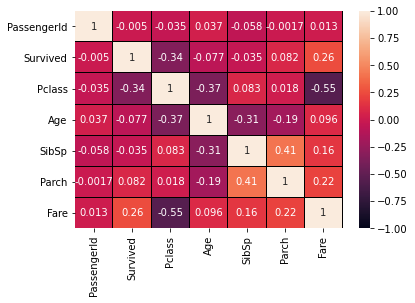

In [5]:
sns.heatmap(titanic_df.corr(), vmin=-1, vmax=1, linewidths=.005, linecolor='black',annot=True)

Possiamo osservare che per il momento non ci sono correlazioni forti tra le colonne del dataset. Le due correlazioni più forti legate alla colonna *survived* sono quelle con la colonna *Fare* (correlazione positiva) e con la colonna *Pclass* (correlazione negativa), ma sono comunque correlazioni deboli, con un valore assoluto intorno a 0.3. Allo stesso tempo, queste due colonne sono moderatamente correlate tra loro in maniera negativa (più bassa la classe, più alto il prezzo del biglietto). Possiamo concludere, quindi, che c'è una certa correlazione tra la qualità degli alloggi dei passeggeri sul Titanic e la loro probabilità di sopravvivenza: è una prima informazione da utilizzare nella nostra fase di *feature engineering* e *feature selection*.

### Valori mancanti

In [6]:
null_data = titanic_df[titanic_df.isnull().any(axis=1)]
display(null_data)
# Which columns have null values?
print('Columns with missing values:', titanic_df.columns[titanic_df.isnull().any()].values)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


Columns with missing values: ['Age' 'Cabin' 'Embarked']


Il porto di imbarco e la cabina probabilmente non sono informazioni molto determinanti ai fini della sopravvivenza. Possiamo quindi aggirare il problema dei dati mancanti per queste due colonne semplicemente non considerandole nella fase di definizione delle features. Lo stesso discorso non può valere per l'età, che possiamo supporre essere un'informazione chiave ai fini della classificazione. Quanti sono i record in cui manca l'età?

In [7]:
titanic_df[ titanic_df['Age'].isnull()].shape[0]

177

Decisamente troppi per pensare di eliminare i record. Quello che si può fare è:
* Aggiungere un campo `age_missing`che vale 1 se l'età non è presente nel dataset, 0 altrimenti;
* Porre le età mancanti uguali all'età minima presente nel training set. Perchè proprio il minimo? Perchè negli algoritmi di *supervised machine learning* è sempre meglio avere valori bassi nelle proprie feature, per evitare di andare a creare delle forti asimmetrie di valori tra le diverse features. Il campo `age_missing` che abbiamo aggiunto servirà al classificatore ad imparare a dare meno peso al valore imputato.

## Feature encoding

In un primo esperimento, cerchiamo di utilizzare le seguenti colonne del dataset per predire la sopravvivenza:
* *Pclass*, che abbiamo visto essere correlata alla sopravvivenza, seppur debolmente;
* *Sex*, che possiamo ipotizzare essere un fattore importante;
* *Age*, come sopra;
* *Fare*, di cui abbiamo osservato una debole correlazione.

Quello che dobbiamo fare, quindi, è:
1. Trasformare il genere in una feature numerica;
2. Gestire i valori mancanti nella colonna dell'età come commentato sopra.
3. Filtrare il dataset per le colonne interessate;

Sostituiamo ai valori *female* 1 e ai valori *male* 0:

In [8]:
gender_encoding = {
    'female': 1,
    'male': 0
}

titanic_df['Sex'].replace(gender_encoding, inplace=True)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


Creiamo una feature che indichi se l'età è mancante in un dato record e rimpiazziamo i dati mancanti con l'età minima presente nel dataset:

In [9]:
min_age = titanic_df['Age'].min()

titanic_df['age_missing'] = titanic_df['Age'].isnull().astype(int)
display(titanic_df)

titanic_df['Age'].fillna(min_age, inplace=True)
display(titanic_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_missing
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,NaN,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,NaN,S,1
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,C,0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_missing
0,1,0,3,"Braund, Mr. Owen Harris",0,22.00,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.00,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.00,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",0,35.00,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.00,0,0,211536,13.0000,NaN,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.00,0,0,112053,30.0000,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,0.42,1,2,W./C. 6607,23.4500,NaN,S,1
889,890,1,1,"Behr, Mr. Karl Howell",0,26.00,0,0,111369,30.0000,C148,C,0


Controlliamo quindi che non ci siano valori mancanti e osserviamo la correlazione tra la sopravvivenza e la colonna ora numerica del genere e dell'età mancante:

In [10]:
df1 = titanic_df[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'age_missing']].copy(deep=True)

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    int64  
 3   Age          891 non-null    float64
 4   Fare         891 non-null    float64
 5   age_missing  891 non-null    int32  
dtypes: float64(2), int32(1), int64(3)
memory usage: 38.4 KB


In [12]:
df1[['Survived', 'Sex', 'age_missing']].corr()

,Survived,Sex,age_missing
Survived,1.000000,0.543351,-0.092197
Sex,0.543351,1.000000,-0.055215
age_missing,-0.092197,-0.055215,1.000000


Sembra che ci sia una moderata correlazione tra il genere e la sopravvivenza, il che potrebbe essere indice di una buona feature. Siamo pronti per fare predizioni!

## Naive Bayes Classification

Per allenare e misurare le performance del modello Naive Bayes usiamo la tecnica di 5-folds cross validation: il dataset viene diviso in 5 subset, il modello viene allenato 5 volte usando ogni volta 4 folds come training set e 1 fold come test set, a rotazione. Il pacchetto `sklearn` ci permette con una semplice chiamata a funzione di fare ciò.

Come modello utilizzeremo `sklearn.naive_bayes.GaussianNB`, il quale cerca di modellare la likelihood delle classi come una Gaussiana.

Una volta scelto il modello, è necessario scegliere quale misura considerare per valutarne le performance. Guardiamo com'è la distribuzione delle 2 classi all'interno del nostro dataset:

In [13]:
df1['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Le classi sono ditribuite con un rapporto 62/38, al limite tra un dataset bilanciato ed uno sbilanciato. Possiamo comunque utilizzare la accuracy come misura della qualità delle nostre predizioni:

In [14]:
y = df1['Survived']
X_df1 = df1.drop('Survived', axis=1)
display(X_df1.sample(5))

,Pclass,Sex,Age,Fare,age_missing
497,3,0,0.42,15.1000,1
285,3,0,33.00,8.6625,0
611,3,0,0.42,7.0500,1
370,1,0,25.00,55.4417,0
809,1,1,33.00,53.1000,0


In [15]:
naive_bayes = GaussianNB()
scores = cross_val_score(naive_bayes, X_df1, y, cv=5)
print(f'Naive Bayes Accuracy - df1: {sum(scores)/len(scores):.4f}')

Naive Bayes Accuracy - df1: 0.7632


Utilizzeremo questo risultato (accuracy del 76%) come *baseline* dei nostri esperimenti: cerchiamo di cambiare la nostra strategia per migliorare la soluzione ottenuta. I cambiamenti da apportare possono essere su due fronti:
1. Utilizzare features diverse e strategie di features encoding differenti
2. Utilizzare altri modelli

### Usare meno features
Talvolta, un alto numero di features dei dati può comportare *overfitting* su di essi. Proviamo a rimuovere le features legate a all'età, visto che non era emersa alcuna correlazione interessante tra età e sopravvivenza:

In [16]:
X_df2 = X_df1.drop(columns=['Age', 'age_missing'])
display(X_df2.head())

,Pclass,Sex,Fare
0,3,0,7.2500
1,1,1,71.2833
2,3,1,7.9250
3,1,1,53.1000
4,3,0,8.0500


In [17]:
scores = cross_val_score(naive_bayes, X_df2, y, cv=5)
print(f'Naive Bayes Accuracy - df2: {sum(scores)/len(scores):.4f}')

Naive Bayes Accuracy - df2: 0.7789


Rimuovere le features legate all'età ha permesso di migliorare leggermente l'accuracy del nostro modello (~1.5%), probabilmente poichè acquisisce una migliore capacità di generalizzare.

## Usare più features

Possiamo provare ad utilizzare più informazioni sui nostri dati, in modo da osservare se queste informazioni possano aiutare il modello a fare predizioni migliori. Proviamo ad aggiungere al nostro dataset features legate a:
* Parenti a bordo;
* Porto di imbarco;
* Titolo del nominativo.

In [18]:
df3 = titanic_df.copy(deep=True)
df3 = titanic_df.drop(columns=['PassengerId', 'Survived', 'Ticket', 'Cabin'])
df3.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,age_missing
0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,0
2,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,0
4,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,0


#### Famiglia a bordo

In [19]:
df3['Family_size'] = df3['SibSp'] + df3['Parch'] + 1
df3.drop(columns=['SibSp', 'Parch'], inplace=True)
df3.head()

,Pclass,Name,Sex,Age,Fare,Embarked,age_missing,Family_size
0,3,"Braund, Mr. Owen Harris",0,22.0,7.2500,S,0,2
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,71.2833,C,0,2
2,3,"Heikkinen, Miss. Laina",1,26.0,7.9250,S,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,53.1000,S,0,2
4,3,"Allen, Mr. William Henry",0,35.0,8.0500,S,0,1


#### Porto di imbarco

In [20]:
print(f"Unique values for Embarked: {df3['Embarked'].unique()}")
print(f"Number of missing values: {df3['Embarked'].isna().sum()}")

Unique values for Embarked: ['S' 'C' 'Q' nan]
Number of missing values: 2


Prima di effettuare feature encoding, dobbiamo gestire i dati mancanti: essendo solo 2 i record per cui manca il valore di *Embarked*, possiamo identificare il porto da cui sono salpati il maggior numero di passeggeri e assegnare i dati mancanti ad esso:

In [21]:
df3['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [22]:
# 'S' is the most frequent value for the 'Embarked' columns, we fill na with this value
df3['Embarked'].fillna('S', inplace=True)
df3['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

Il metodo più corretto per effettuare l'encoding di una variabile categorica di questo tipo sarebbe il *One-Hot Encoding*, in quanto non esiste alcun tipo di ordinamento tra le diverse categorie (ovvero i diversi porti di imbarco). Tuttavia, una soluzione di questo tipo aumenterebbe di molto il numero di features del dataset e questo potrebbe causare overfitting, perciò utilizzeremo lo sesso un encoding ordinale:

In [23]:
df3['Embarked'] = df3['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
df3.head()

,Pclass,Name,Sex,Age,Fare,Embarked,age_missing,Family_size
0,3,"Braund, Mr. Owen Harris",0,22.0,7.2500,0,0,2
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,71.2833,1,0,2
2,3,"Heikkinen, Miss. Laina",1,26.0,7.9250,0,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,53.1000,0,0,2
4,3,"Allen, Mr. William Henry",0,35.0,8.0500,0,0,1


#### Titolo

In [24]:
df3['Title'] = df3.Name.str.extract('([A-Za-z]+)\.', expand=False)
df3['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Sir           1
Capt          1
Ms            1
Countess      1
Mme           1
Jonkheer      1
Don           1
Lady          1
Name: Title, dtype: int64

Con una semplice regular expression abbiamo estratto tutti i titoli dai nomi. Possiamo osservare che alcuni possono essere accorpati, ad esempio: *Mme*/*Mlle* (Madame/Mademoiselle) &#9654; *Miss*/*Mrs*. Inoltre, *Ms* e *Miss* sono lo stesso titolo espresso con abbreviazioni diverse.

Oltre a ciò, ci sono numerosi titoli che occorrono pochissime volte nel nostro dataset: possiamo creare un'unica categoria *Other* in cui facciamo rientrare tutti i titoli rari.

In [25]:
df3['Title'] = df3['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

df3['Title'] = df3['Title'].replace('Mlle', 'Miss')
df3['Title'] = df3['Title'].replace('Ms', 'Miss')
df3['Title'] = df3['Title'].replace('Mme', 'Mrs')
df3.Title.value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: Title, dtype: int64

Una volta raffinate le nostre categorie, effettuiamo un encoding ordinale per gli stessi motivi riportati per la colonna *Embarked*:

In [26]:
df3['Title'] = df3['Title'].map({'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Other': 5})
df3.drop(columns='Name', inplace=True)
df3.head()

,Pclass,Sex,Age,Fare,Embarked,age_missing,Family_size,Title
0,3,0,22.0,7.2500,0,0,2,1
1,1,1,38.0,71.2833,1,0,2,3
2,3,1,26.0,7.9250,0,0,1,2
3,1,1,35.0,53.1000,0,0,2,3
4,3,0,35.0,8.0500,0,0,1,1


#### Naive Bayes

In [27]:
scores = cross_val_score(naive_bayes, df3, y, cv=5)
print(f'Naive Bayes Accuracy - df3: {sum(scores)/len(scores):.5f}')

Naive Bayes Accuracy - df3: 0.79130


Ancora una volta, siamo riusciti a migliorare leggermente l'accuracy del modello, questa volta aggiungendo informazioni rilevanti per la classificazione.

## Utilizzare diversi modelli

Abbiamo visto come sia possibile migliorare la accuratezza delle predizioni lavorando sulle features del dataset. Ora proviamo a comparare i risultati di altri algoritmi di machine learning rispetto al Naive Bayes con cui abbiamo sperimentato finora. Utilizziamo alcuni algoritmi tra i più semplici e diffusi: 
* **Logistic Regression**: ricavata dallo stesso Naive Bayes per calcolare una probabilità a posteriori anzichè una likelihood, è un classificatore lineare;
* **Decision Tree**: un algoritmo di learning che allena un albero decisionale sui dati, molto semplice;
* **Random Forest**: un metodo di insieme che combina i risultati di tanti semplici alberi decisionali.

In [33]:
datasets = [X_df1, X_df2, df3]
algorithms = [
    {'name': 'Naive Bayes', 'model': naive_bayes}, 
    {'name': 'Logistic Regression', 'model': LogisticRegression(max_iter=200)},
    {'name': 'Decision Tree', 'model': DecisionTreeClassifier()},
    {'name': 'Random Forest', 'model': RandomForestClassifier(n_estimators=150)}
]
cols = ['Model Name', 'Baseline', 'Less Features', 'More Features']

summary = pd.DataFrame(columns=cols)
for alg in algorithms:
    row = [alg['name']]
    
    for X in datasets:
        results = []
        
        # We train and test each model 3 times and we compute the average score,
        # in order to have more robust results
        for _ in range(3):
            results.extend(cross_val_score(alg['model'], X, y, cv=5))
        row.append(sum(results)/len(results))
    summary = summary.append(pd.Series(data=row, index=cols), ignore_index=True)

summary.set_index('Model Name', inplace=True)
display(summary)

,Baseline,Less Features,More Features
Model Name,,,
Naive Bayes,0.763248,0.778909,0.791300
Logistic Regression,0.776687,0.782255,0.811456
Decision Tree,0.779723,0.812629,0.770640
Random Forest,0.815609,0.805158,0.806595


Si può osservare come questi algoritmi migliorino i risultati ottenuti in termini di accuracy rispetto al Naive Bayes:
* La *Logistic Regression*, poichè non modella la probabilità dei dati (ovvero la Likelihood) ma quella delle classi a partire dai dati (ovvero la probabilità a posteriori), è capaci di gestire features più numerose e complesse in maniera più robusta all'overfitting, perciò fornisce le predizioni migliori sul dataset con più features (~81% di accuracy)
* Il *Decision Tree* è un algoritmo molto semplice e quindi a rischio overfitting, per questo performa al meglio sul dataset più semplice;
* Il *Random Forest* è senz'altro l'algoritmo più utilizzato e popolare poichè sfrutta la potenza dei metodi di insieme. Si può vedere come i risultati sui 3 dataset siano molto vicini tra di loro e migliori di quelli ottenuti dal Naive Bayes.

> NOTA: i 5 *folds* su cui sono allenati i modelli vengono generati in maniera random, quindi i risultati cambiano ad ogni run. Per questo motivo, i risultati ottenuti potrebbero leggermente differire da quelli ottenuti dall'autore e su cui si basano i commenti. Ogni modello viene allenato e testato per 3 volte su 5 folds, quindi 3/5 = 15 volte, e viene riportata nel sommario finale la media dei risultati ottenuti, proprio per avere un quadro più preciso dei risultati di ciascun algoritmo su ciascun dataset. Non si dovrebbero ottenere dunque risultati molto distanti da quelli commentati.